# Unscented Kalman Filter Localization

## Timothy Devon Morris

### Unscented Kalman Filter
When the state transition and observation models—that is, the predict and update functions 
$f$ and $h$ are highly non-linear, the extended Kalman filter can give particularly poor performance. This is because the covariance is propagated through linearization of the underlying non-linear model. The unscented Kalman filter (UKF) uses a deterministic sampling technique known as the unscented transform to pick a minimal set of sample points (called sigma points) around the mean. These sigma points are then propagated through the non-linear functions, from which a new mean and covariance estimate are then formed. The result is a filter which, for certain systems, more accurately estimates the true mean and covariance.

In [1]:
from __future__ import division
import numpy as np
import numpy.linalg as la
import scipy.linalg as sla
from IPython.display import display,HTML
import matplotlib.pyplot as plt
from matplotlib import animation, rc

### Robot Motion Class
Our 2D robot has a state vector consisting of $(x, y , \theta)^T$. We assume that our robot follows a nonlinear dynamics model implemented with a velocity controller on $v$ and $\omega$. Together $(v,\omega)^T = u$. Thus,
$\mathbf{x}_t = f(\mathbf{x}_{t-1},u)$
where

$$f(\mathbf{x}_{t-1},u) = 
\begin{bmatrix}
x_{t-1} \\
y_{t-1} \\
\theta_{t-1}
\end{bmatrix} + 
\begin{bmatrix}
-\frac{v}{\omega}\sin{\theta_{t-1}} + \frac{v}{\omega}\sin{(\theta_{t-1} + \omega \Delta t)} \\
\frac{v}{\omega}\cos{\theta_{t-1}} - \frac{v}{\omega}\cos{(\theta_{t-1} + \omega \Delta t)} \\
\omega \Delta t
\end{bmatrix}$$

We assume that with our control input $u$ we have associated noise 

$$
\begin{bmatrix}
\hat{v} \\
\hat{\omega}
\end{bmatrix} =
\begin{bmatrix}
v \\
\omega
\end{bmatrix}
+ 
\begin{bmatrix}
\varepsilon_{\alpha_1 v^2 + \alpha_2 \omega^2} \\
\varepsilon_{\alpha_3 v^2 + \alpha_4 \omega^2}
\end{bmatrix}$$

where $\varepsilon_{b^2} \sim \mathcal{N}(0,b^2)$

Note: the velocity motion model doesn't work for straight line motion, this is because we divide by $\omega$.



In [2]:
class VCRobot(object):
    '''
    Class to implement a velocity controlled two-wheeled robot
    
    The robot has state (x, y, theta) 
    The motion model is described in Probabilistic Robotics by Thrun ch. 5d
    '''
    def __init__(self, dt, alpha):
        '''
        member variables:
        dt - time step
        alpha - numpy array (4) describing noise characteristics
        '''
        self.dt = dt
        self.alpha = alpha
    
    def generate_motion(self,v,w,x0):
        '''
        inputs:
        v - numpy array (T) describing velocity
        w - numpy array (T) describing angular velocity
        x0 - numpy array (3) describing initial position
        
        outputs:
        X - numpy array (T,3) describing state at each time step
        '''
        dt = self.dt
        alpha = self.alpha
        T = len(v)
        
        X = np.zeros((T+1,3))
        X[0,:] = x0
        
        for t in xrange(T):
            var1 = alpha[0]*v[t]**2 + alpha[1]*w[t]**2
            var2 = alpha[2]*v[t]**2 + alpha[3]*w[t]**2
            v_hat = v[t] + np.sqrt(var1)*np.random.randn()
            w_hat = w[t] + np.sqrt(var2)*np.random.randn()
            stheta = np.sin(X[t,2])
            ctheta = np.cos(X[t,2])
            sthetap = np.sin(X[t,2] + dt*w_hat)
            cthetap = np.cos(X[t,2] + dt*w_hat)
            
            X[t+1,0] = X[t,0] - v_hat/w_hat*stheta + v_hat/w_hat*sthetap
            X[t+1,1] = X[t,1] + v_hat/w_hat*ctheta - v_hat/w_hat*cthetap
            X[t+1,2] = X[t,2] + w_hat*dt
        
        return X
        
class LocalizationAnimation(object):
    '''
    Class to visualize the 2D localization problem for a two-wheeled robot
    
    The robot has state (x, y, theta)
    The motion model is described in Probabilistic Robotics by Thrun ch. 5d
    '''
    def __init__(self, X, Y,dt):
        '''
        member variables:
        X - numpy array (T,3) state of the robot
        Y - numpy array (m,2) Locations of landmarks
        '''
        self.X = X
        self.Y = Y
        self.dt = dt
    
    def animate(self):
        '''
        X - numpy array (3,T) describing state at each time step
        '''
        X = self.X
        Y = self.Y
        dt = self.dt
        T = X.shape[0]
        
        xm = -20
        xM = 20
        ym = -20
        yM = 20
        
        env = plt.figure(figsize=(8, 8))
        ax = env.add_subplot(1, 1, 1)
        ax.set_xlim((xm, xM))
        ax.set_ylim((ym, yM))
        ax.set_title("Robot Environment",fontsize=20)
        ax.set_xlabel("X position (m)", fontsize=16)
        ax.set_ylabel("Y position (m)", fontsize=16)
        
        robot = plt.Circle((X[0, 0], X[0, 1]), 1, fill=False)
        ax.add_artist(robot)
        direction = np.array([[0, np.cos(X[0, 2])], [0, np.sin(X[0, 2])]])
        line, = ax.plot(X[0, 0] + direction[0, :], X[1, 0] + direction[1, :], 'k')
        features, = ax.plot(Y[:, 0], Y[:, 1], 'gD')

        def animate(i):
            direction = np.array([[0, np.cos(X[i, 2])], [0, np.sin(X[i, 2])]])
            line.set_data(X[i, 0] + direction[0, :], X[i, 1] + direction[1, :])
            robot.center = X[i, 0], X[i, 1]
            return (line,)
        
        anim = animation.FuncAnimation(env, animate, frames=T, interval=dt*500, blit=True)
        return anim

In [3]:
dt = .1
alpha = np.array([.1, .01, .01, .1])
t = np.arange(0,20.1, dt)
x0 = np.array([-5, -3, np.pi/2])
Y = np.array([[6., 4.],
              [-7., 8.],
              [6., -4]])
R = np.array([[.01, .0],
              [0., .0025]])

v = 1 + .5*np.cos(.4*np.pi*t)
w = -.2 + 2*np.cos(1.2*np.pi*t)
robot = VCRobot(dt, alpha)
X = robot.generate_motion(v,w,x0)
ani = LocalizationAnimation(X,Y,dt)
HTML(ani.animate().to_html5_video())

### Landmarks
As seen in the plot above, we assume there are a number of stationary landmarks from which the robot can take range and bearing measurements. Since these landmarks have fixed position, we can use these measurements to determine our location and bearing. For each landmark $m$ we have an associated $\mathbf{x}_m = (x_m, y_m)^T$ denoting it's position. Since range is a norm and the bearing uses arctangent, this measurement model is inherently nonlinear. We denote this by
$\mathbf{z}_{t,m} = h(\mathbf{x}_{t}, \mathbf{x}_{m}, u)$.
Explicitly,

$$h(\mathbf{x}_t, \mathbf{x}_m, u) = 
\begin{bmatrix}
\sqrt{(x_m - x_t)^2 + (y_m - y_t)^2} \\
\arctan2{\frac{y_m - y_t}{x_m - x_t}}
\end{bmatrix}
$$

Note: In this case and many others, our measurement model does not directly depend on our control input $u$.

In [4]:
class LandmarkSensor(object):
    '''
    Class to simulate a landmark sensor
    This is a basic range-bearing sensor in 2D
    '''
    
    def __init__(self, Y, R):
        '''
        member variables:
        Y - numpy array (m, 2) locations of the landmarks
        R - noise covariance associated with range and bearing
        '''
        self.Y = Y
        self.R = R
        
    def simulate(self, X):
        '''
        inputs:
        X - numpy array (T,3) of vehicle state (x,y, theta)
        
        outputs:
        Z - numpy array (T,2*m) of range/bearing measurements
        '''
        Y = self.Y
        m, _ = Y.shape
        T, _ = X.shape
        
        Z = np.zeros((T,2*m))
        
        for i in xrange(m):
            Z[:, 2*i] = np.linalg.norm(X[:, 0:2] - self.Y[i,:], axis=1)
            Z[:, 2*i+1] = np.arctan2(self.Y[i,1] - X[:,1], self.Y[i,0] - X[:,0]) - X[:,2]
            
        for t in xrange(T):
            for i in xrange(m):
                Z[t, 2*i:2*i+2] += np.random.multivariate_normal(np.zeros(2), self.R)  
        return Z

In [5]:
rbsensor = LandmarkSensor(Y,R)
Z = rbsensor.simulate(X[1:,:])

### Unscented Kalman Filter Class
The UKF works by sampling the prior at certain deterministic sigma points and pushing these through both the nonlinear motion model and the nonlinear observation model. Once again, we assume that we have a motion model given by $f$ and a observation model given by $h$. Since we are performing the localization problem with noisy control inputs, we will first augment our state and covariance matrices and then perform a typical UKF propogation and update.

#### Generate augmented mean and covariance

$$M_t = \begin{bmatrix}
\alpha_1 v_t^2 + \alpha_2 \omega_t^2 & 0 \\
0 & \alpha_3 v_t^2 + \alpha_4\omega_t^2 \end{bmatrix}$$

$$Q_t = \begin{bmatrix}
\sigma_r^2 & 0 \\
0 & \sigma_{\phi}^2 \end{bmatrix}$$

$$\mu_t^a = (\mu_{t-1}^T\ (0\ 0)\ (0\ 0))^T$$

$$\Sigma_{t-1}^a = \begin{bmatrix}
\Sigma_{t-1} & \mathbf{0} & \mathbf{0} \\
\mathbf{0} & M_t & \mathbf{0} \\
\mathbf{0} & \mathbf{0} & Q_t \end{bmatrix}$$

#### Generate sigma points
$$\mathcal{X}_{t-1}^a = (\mu_{t-1}^a\ \mu_{t-1}^a + \gamma\sqrt{\Sigma_{t-1}^a}\ \mu_{t-1}^a + \gamma\sqrt{\Sigma_{t-1}^a})$$

#### Predict Positions
$$\bar{\mathcal{X}}_t^x = f(\mathcal{X}_{t-1}^x, u_t + \mathcal{X}_t^u)$$

$$\bar{\mu}_t = \sum_{i=0}^{2L} w_i^{(m)} \bar{\mathcal{X}}_{i,t}^x$$

$$\bar{\Sigma}_t = \sum_{i=0}^{2L} w_i^{(c)} (\bar{\mathcal{X}}_{i,t}^x - \bar{\mu})(\bar{\mathcal{X}}_{i,t}^x - \bar{\mu})^T$$

#### Predict Measurements
$$\bar{\mathcal{Z}} = h(\bar{\mathcal{X}}_t^x) + \mathcal{X}_t^z$$

$$\hat{z}_t = \sum_{i=0}^{2L} w_i^{(m)} \bar{Z}_{i,t}$$

$$S_t = \sum_{i=0}^{2L} w_i^{(c)} (\bar{\mathcal{Z}}_{i,t} - \hat{z}_t)(\bar{\mathcal{Z}}_{i,t} - \hat{z}_t)^T$$

$$\Sigma_{t}^{x,z} = \sum_{i=0}^{2L} w_i^{(c)}(\bar{\mathcal{X}}_{i,t}^x - \bar{\mu})(\bar{\mathcal{Z}}_{i,t} - \hat{z}_t)^T$$

#### Update

$$K_t = \Sigma_{t}^{x,z}S_t^{-1}$$

$$\mu_t = \bar{\mu}_t + K_t(z_t - \hat{z}_t)$$

$$\Sigma_t = \bar{\Sigma}_t - K_tS_tK_t^T$$

In [6]:
class UKF(object):
    '''
    Class to implement UKF localization for a single landmark
    for a system with noise on the control inputs
    '''
    def __init__(self,f,h,Q,R):
        '''
        Class Variables:
        f(x,u) - function handle nonlinear state transition
        h(x,y,u) - function handle nonlinear measurement model
        Q(u) - function handle Covariance of input
        R - numpy matrix (mxm) sensor noise covariance
        '''
        self.f = f
        self.h = h
        self.Q = Q
        self.R = R
    
    def filter(self, Z, U, Y, x0, alpha=1, beta=2, kappa=0):
        '''
        Filters over a fixed number of time steps
        
        Inputs:
        Z - numpy matrix (Txm) measurements for T time steps
        U - numpy matrix (Txk) controls for T time steps
        x0 - numpy matrix (nx1) initial guess of position
        
        Outputs:
        X - numpy matrix (Txn) 
        '''
        n = x0.shape[0]
        _,k = U.shape
        T,m = Z.shape
        X = np.zeros((T+1,n))
        C = np.zeros((T+1,3))
        X[0,:] = x0
        Cov = np.eye(n)
        m = 2
        
        n_chi = n + k + m
        w_m = np.zeros(2*n_chi + 1)
        w_c = np.zeros(2*n_chi + 1)
        
        lamb = alpha**2*(n_chi+kappa)-n_chi
        w_m[:] = .5/(n_chi + lamb)
        w_c[:] = .5/(n_chi + lamb)
        w_m[0] = lamb/(lamb + n_chi)
        w_c[0] = lamb/(lamb + n_chi) + (1 - alpha**2 + beta)
        gamma = np.sqrt(lamb + n_chi)
        
        C[0,:] = np.diag(Cov)
        for t,u in enumerate(U):
            # Generate augmented mean and covariance
            Q = self.Q(u)
            
            mu_a = np.concatenate((X[t,:],np.zeros(4)))
            Cov_a = sla.block_diag(Cov, Q, self.R)
            
            # Generate sigma points
            chol_a = la.cholesky(Cov_a).T
            Chi_a = np.column_stack([mu_a, (mu_a + gamma*chol_a.T).T, (mu_a - gamma*chol_a.T).T])
            
            # Pass sigma points through motion model and compute Gaussian statistics
            Chi_x = Chi_a[0:n,:]
            Chi_u = Chi_a[n:n+k,:]
            bChi_x = self.f(Chi_x,(u + Chi_u.T).T)
            mu = np.sum(bChi_x*w_m ,axis=1)
            Cov = ((-mu + bChi_x.T).T*w_c).dot(-mu + bChi_x.T)
            
            # Predict Observation sigma points and compute Gaussian statistics
            lm = t%Y.shape[0]
            y = Y[lm]
            y = np.atleast_2d(y).T
            Chi_z = Chi_a[-m:,:]
            Sig_z = self.h(bChi_x, y, u) + Chi_z
            z_hat = np.sum(Sig_z*w_m ,axis=1)
            S = ((-z_hat + Sig_z.T).T*w_c).dot(-z_hat + Sig_z.T)
            Cov_xz = ((-mu + bChi_x.T).T*w_c).dot(-z_hat + Sig_z.T)

            # Perform measurement update
            K = Cov_xz.dot(la.inv(S))
            mu += K.dot(Z[t,2*lm:2*lm+2] - z_hat)
            Cov = Cov - K.dot(S).dot(K.T)
            
            C[t+1,:] = np.diag(Cov)
            X[t+1] = mu.flatten()
        return X, C

In [7]:
def f(x,u):
    xp = np.array(np.zeros_like(x))
    v = u[0]
    w = u[1]
    stheta = np.sin(x[2])
    ctheta = np.cos(x[2])
    sthetap = np.sin(x[2] + dt*w)
    cthetap = np.cos(x[2] + dt*w)

    xp[0] = x[0] - v/w*stheta + v/w*sthetap
    xp[1] = x[1] + v/w*ctheta - v/w*cthetap
    xp[2] = x[2] + w*dt
    return xp

def h(x,y,u):
    _, n = x.shape
    m, _ = y.shape
    zp = np.zeros((m,n))
    
    zp[0] = np.linalg.norm(x[0:2] - y, axis=0)
    zp[1] = np.arctan2(y[1] - x[1], y[0] - x[0]) - x[2]
    return zp 

def Qt(u):
    k = u.shape[0]
    v = u[0]
    w = u[1]
    Q = np.matrix(np.zeros((k,k)))
    Q[0,0] = alpha[0]*v**2 + alpha[1]*w**2
    Q[1,1] = alpha[2]*v**2 + alpha[3]*w**2
    return Q

U = np.column_stack([v, w])
x0 = np.array([-5, -3, np.pi/2])

ukf = UKF(f,h,Qt,R)

In [8]:
X_hat, C = ukf.filter(Z, U, Y, x0)

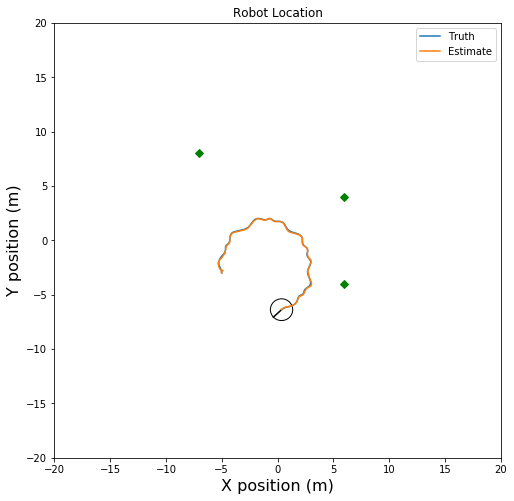

In [9]:
plt.plot(X[:,0],X[:,1],label="Truth")
plt.plot(X_hat[:,0], X_hat[:,1],label="Estimate")
plt.title("Robot Location")
plt.legend()
plt.show()

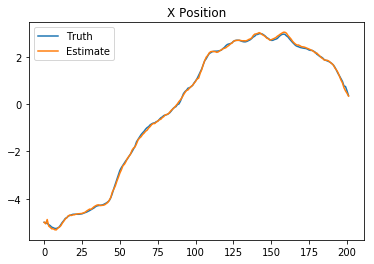

In [10]:
plt.plot(X[:,0],label="Truth")
plt.plot(X_hat[:,0],label="Estimate")
plt.title("X Position")
plt.legend()
plt.show()

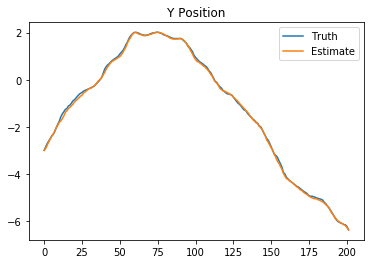

In [11]:
plt.plot(X[:,1],label="Truth")
plt.plot(X_hat[:,1],label="Estimate")
plt.title("Y Position")
plt.legend()
plt.show()

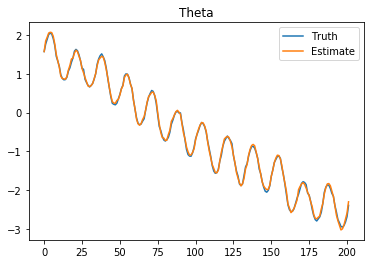

In [12]:
plt.plot(X[:,2],label="Truth")
plt.plot(X_hat[:,2],label="Estimate")
plt.title("Theta")
plt.legend()
plt.show()

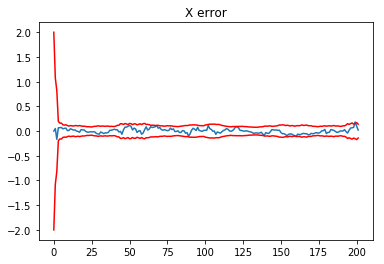

In [13]:
plt.plot(X[:,0]-X_hat[:,0])
plt.plot(2*np.sqrt(C[:,0]), color='r')
plt.plot(- 2*np.sqrt(C[:,0]), color='r')
plt.title("X error")
plt.show()

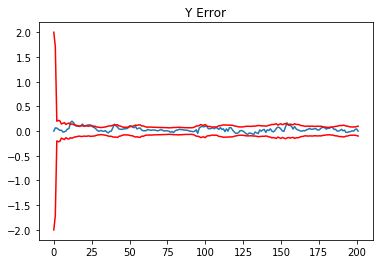

In [14]:
plt.plot(X[:,1]-X_hat[:,1])
plt.plot(2*np.sqrt(C[:,1]), color='r')
plt.plot(- 2*np.sqrt(C[:,1]), color='r')
plt.title("Y Error")
plt.show()

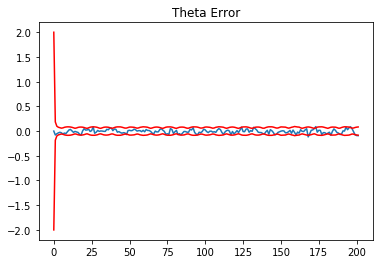

In [15]:
plt.plot(X[:,2]-X_hat[:,2])
plt.plot(2*np.sqrt(C[:,2]), color='r')
plt.plot(- 2*np.sqrt(C[:,2]), color='r')
plt.title("Theta Error")
plt.show()